# **RECONOCIMIENTO ESTADÍSTICO DE PATRONES**

---
*Nombre:* Pedro Alejandro Astaiza Perafán <br>
*Materia:* Reconocimiento Estadístico de Patrones <br>
*Maestría en Electrónica y Telecomunicaciones* <br>
*Universidad del Cauca*

# **0. Preparación del ambiente**

---



In [3]:
# Librerías
# Ingesta y manipulación de documentos.
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
# Extracción de características
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.signal import get_window
from scipy.signal.windows import hann, hamming
from scipy.integrate import simps
from librosa import feature
from librosa import zero_crossings
import pywt
# Preprocesamiento y validación cruzada
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
# Modelado y entranamiento
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
# Evaluación y métricas de desempeño
from sklearn.metrics import classification_report, confusion_matrix
# Graficos y visualizaciones
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## **1. Ingesta del conjunto de datos**

---


En esta sección se cargan los directorios del archivo, se extraen las etiquetas o marcados y se lee la señal de audio (*.wav*). Dado que la señal tiene dos canales, en este caso se usa la media aritmética de ambos canales para obtener una sola señal.<br>
<center>
  <h2>
$y=\frac{x[0]+x[1]}{2}$
  </h2>
</center>

In [ ]:
# Cargue de datos
directorioDocumentos = '/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENTO ESTADÍSTICO DE PATRONES/Conjunto de datos'
dfArchivos = pd.DataFrame({'archivo':[archivo.as_posix() for archivo in Path(directorioDocumentos.replace(":","")).glob('*/*')]})
dfArchivos['etiqueta'] = dfArchivos['archivo'].apply(lambda x: x.split('/')[7])
dfArchivos['etiqueta'].value_counts()

pasillo      30
vallenato    30
cumbia       30
joropo       30
carranga     30
Name: etiqueta, dtype: int64

In [ ]:
# Lectural de la señal de audio y frecuencia de muestreo
dfArchivos['senhal'] = dfArchivos.archivo.apply(lambda x: wavfile.read(x)[1])
dfArchivos['senhal'] = dfArchivos.senhal.apply(lambda x: (x[:,0]+x[:,1])*0.5)
dfArchivos['senhal'] = dfArchivos.senhal.apply(lambda x: x[0:int(5*44100)]) # Se toman 5 segundos.
dfArchivos['fs'] = 44100
dfArchivos.head(5)

<ipython-input-54-91734b0a74fc>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  dfArchivos['senhal'] = dfArchivos.archivo.apply(lambda x: wavfile.read(x)[1])


,archivo,etiqueta,senhal,fs
0,/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENT...,pasillo,"[-3671.5, -3728.5, -3838.5, -4193.5, -4686.0, ...",44100
1,/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENT...,pasillo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100
2,/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENT...,pasillo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100
3,/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENT...,pasillo,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100
4,/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENT...,pasillo,"[4.0, 4.0, 4.0, 4.5, 4.5, 4.0, 3.5, 3.5, 5.0, ...",44100


In [ ]:
dfSenhal = dfArchivos[['senhal','fs','etiqueta']]
dfSenhal.head(5)

,senhal,fs,etiqueta
0,"[-3671.5, -3728.5, -3838.5, -4193.5, -4686.0, ...",44100,pasillo
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo
4,"[4.0, 4.0, 4.0, 4.5, 4.5, 4.0, 3.5, 3.5, 5.0, ...",44100,pasillo


## **2. Preprocesamiento**

---



### **2.1. Normalización**

---



In [ ]:
dfSenhal['sNorm'] = dfSenhal.senhal.apply(lambda x: (x-np.mean(x))/np.std(x))
dfSenhal['sNorm'].values[0:4]

array([array([-0.8185029 , -0.8312727 , -0.85591617, ..., -0.78904275,
              -0.72653795, -0.69237314])                              ,
       array([ 0.00258368,  0.00258368,  0.00258368, ..., -0.90717595,
              -1.2029343 , -1.43723488])                              ,
       array([-0.00833484, -0.00833484, -0.00833484, ..., -0.54784798,
              -0.44603697, -0.39821988])                              ,
       array([ 6.18769454e-05,  6.18769454e-05,  6.18769454e-05, ...,
              -7.41049827e-01, -8.47711786e-01, -8.69654505e-01])    ],
      dtype=object)

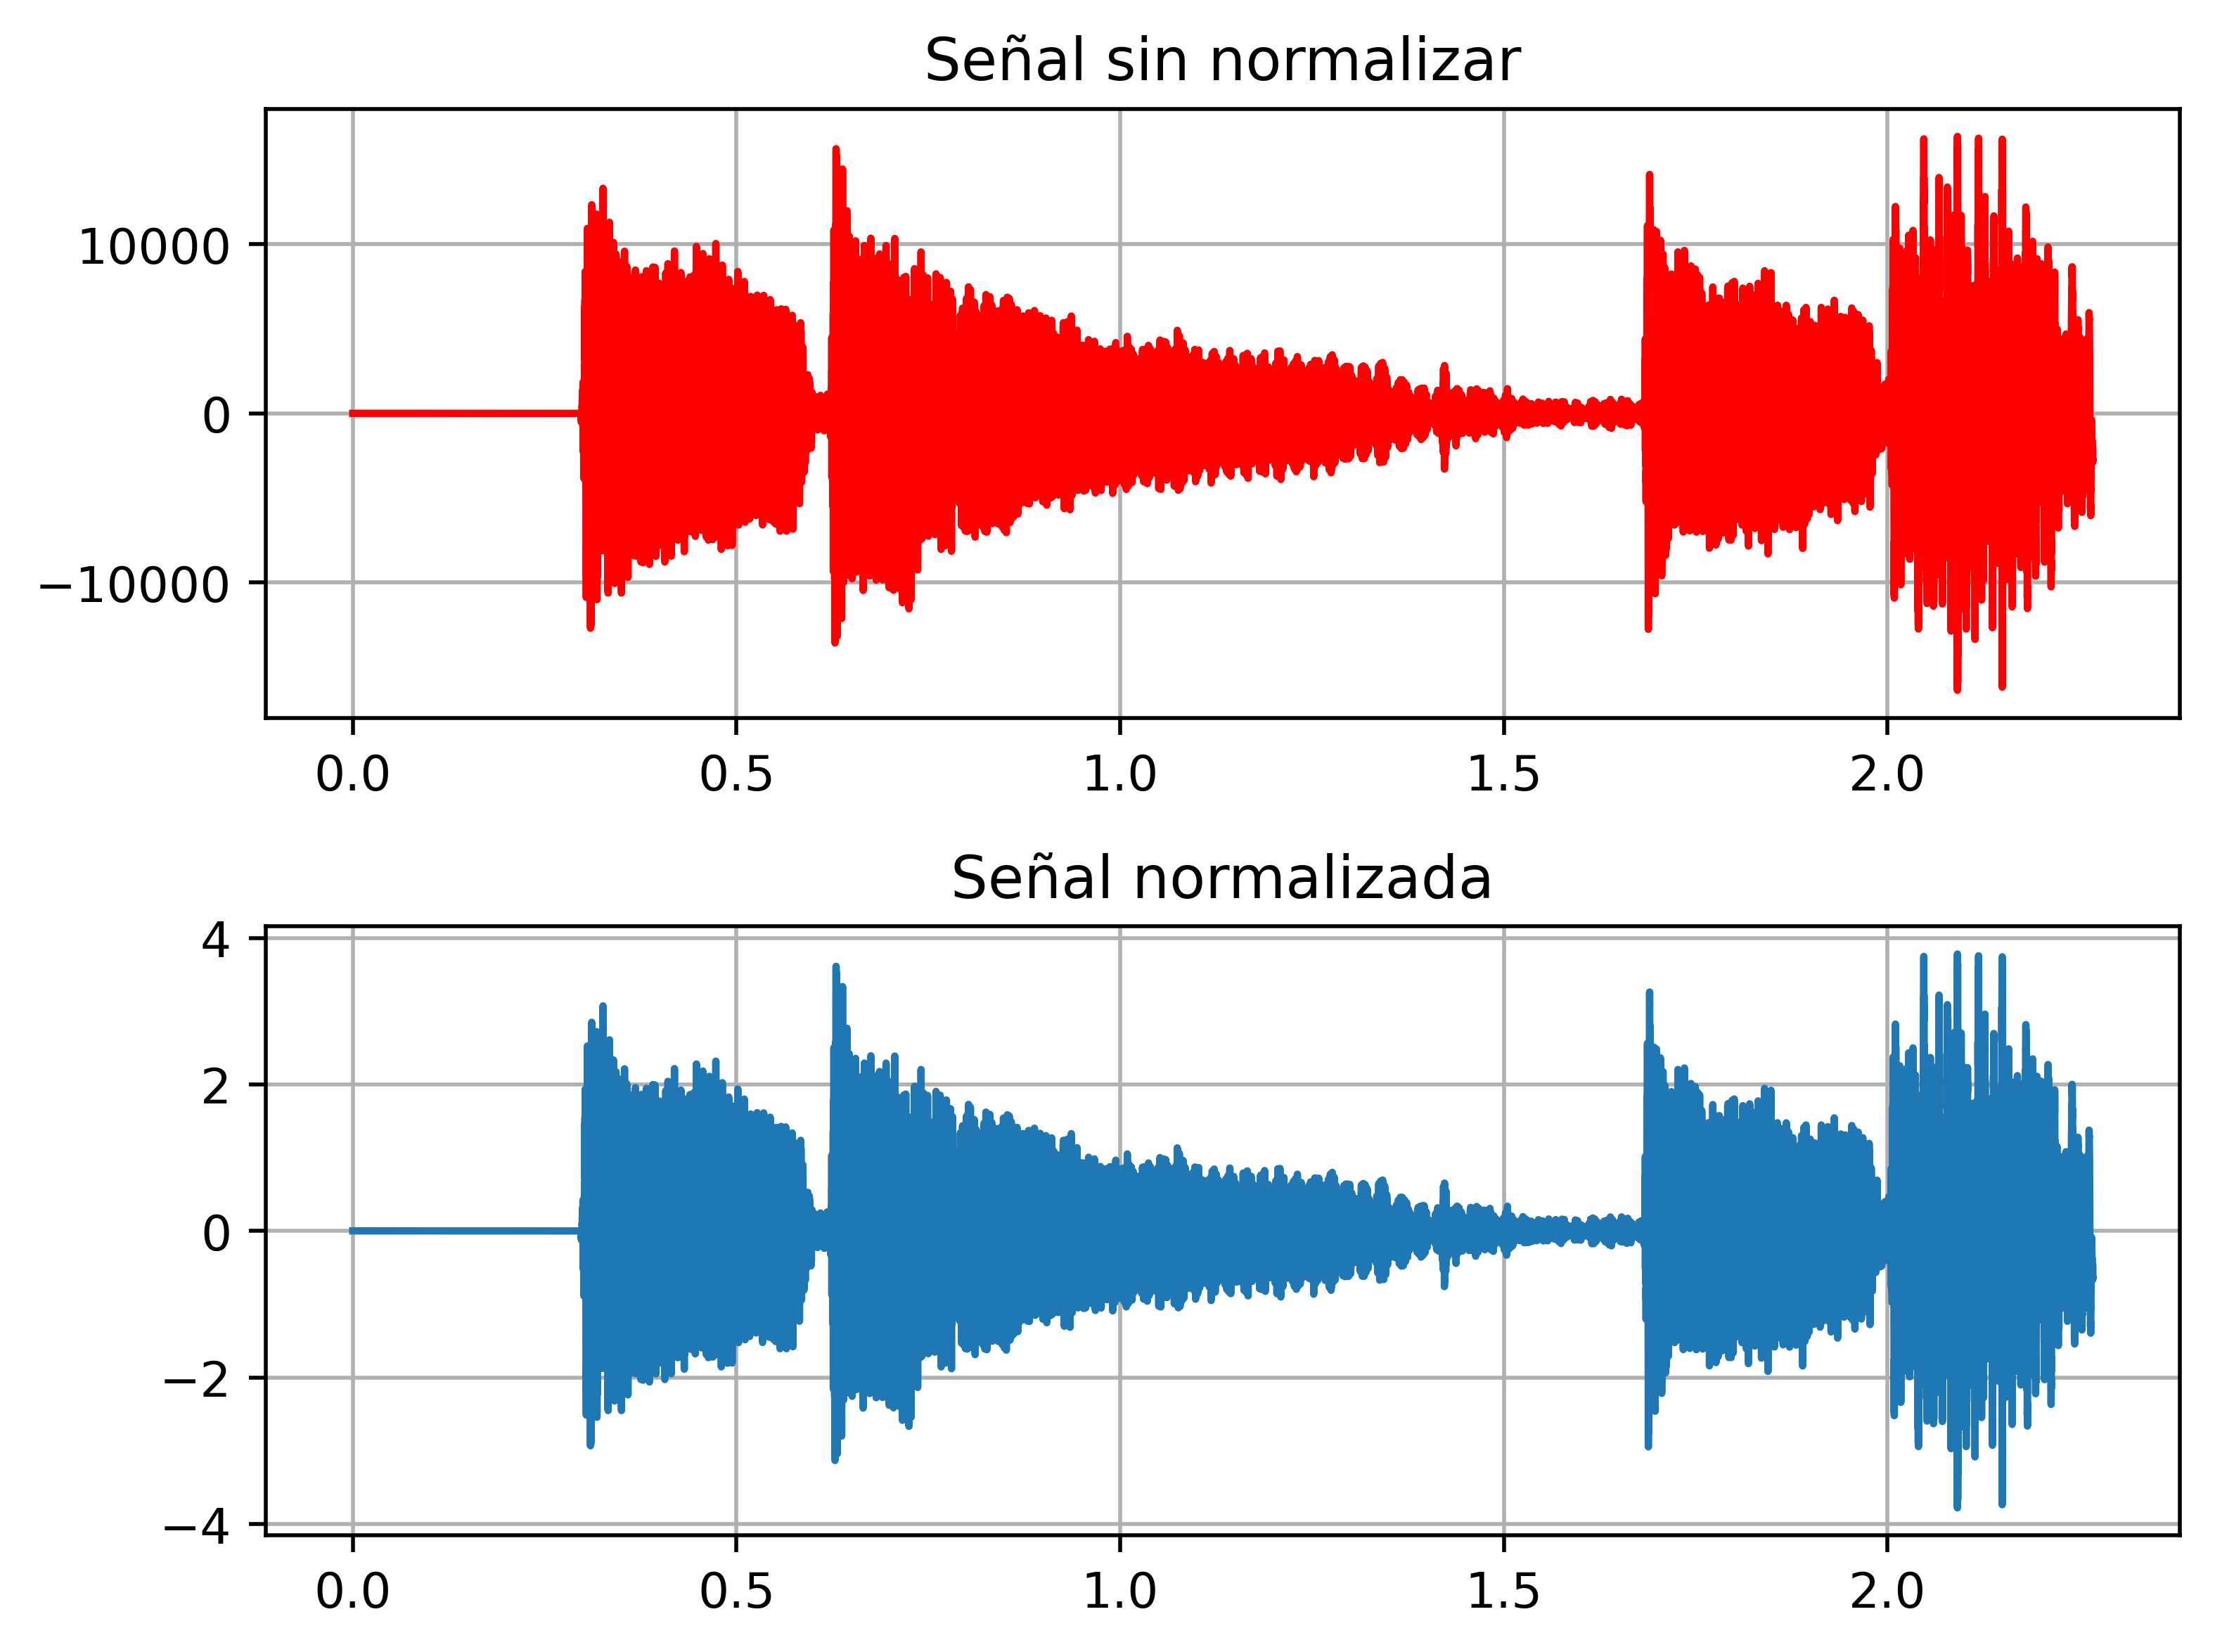

In [ ]:
#@title ejecute esta celda para visualizar
x = dfSenhal['senhal'].values[1][0:100000]
x_n = dfSenhal['sNorm'].values[1][0:100000]
fs = 44100
t = np.linspace(0,len(x)/44100,len(x))
fig,axes = plt.subplots(ncols=1,nrows=2,dpi=500)
sns.lineplot(x=t,y=x,ax=axes[0],color='r')
axes[0].set_title('Señal sin normalizar')
axes[0].grid()
sns.lineplot(x=t,y=x_n,ax=axes[1])
axes[1].set_title('Señal normalizada')
axes[1].grid()
fig.tight_layout()
fig.savefig('../document/img/Señales_norm.png')

### **2.2. Ventaneo (*Windowing*)**

---



In [ ]:
def ventana_audio(x,fs):
  T = 0.2 #200ms
  ventanas_rectangulares = np.reshape(a=x,newshape=(int(len(x)/int(T*fs)),int(int(T*fs))))
  return ventanas_rectangulares*hann(int(fs*T))

In [ ]:
dfSenhal['ventanas'] = dfSenhal.sNorm.apply(lambda x: ventana_audio(x,fs=44100))
dfSenhal.head(5)

,senhal,fs,etiqueta,sNorm,ventanas
0,"[-3671.5, -3728.5, -3838.5, -4193.5, -4686.0, ...",44100,pasillo,"[-0.8185029012107448, -0.8312726997670014, -0....","[[-0.0, -1.054883646345202e-07, -4.34462412582..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo,"[0.002583679789316407, 0.002583679789316407, 0...","[[0.0, 3.278685271279117e-10, 1.31147394228434..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo,"[-0.008334841926014051, -0.008334841926014051,...","[[-0.0, -1.0576900270018456e-09, -4.2307595717..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,pasillo,"[6.187694543473044e-05, 6.187694543473044e-05,...","[[0.0, 7.852173882672557e-12, 3.14086915496869..."
4,"[4.0, 4.0, 4.0, 4.5, 4.5, 4.0, 3.5, 3.5, 5.0, ...",44100,pasillo,"[0.003319433097569686, 0.003319433097569686, 0...","[[0.0, 4.212354971773681e-10, 1.68494177514569..."


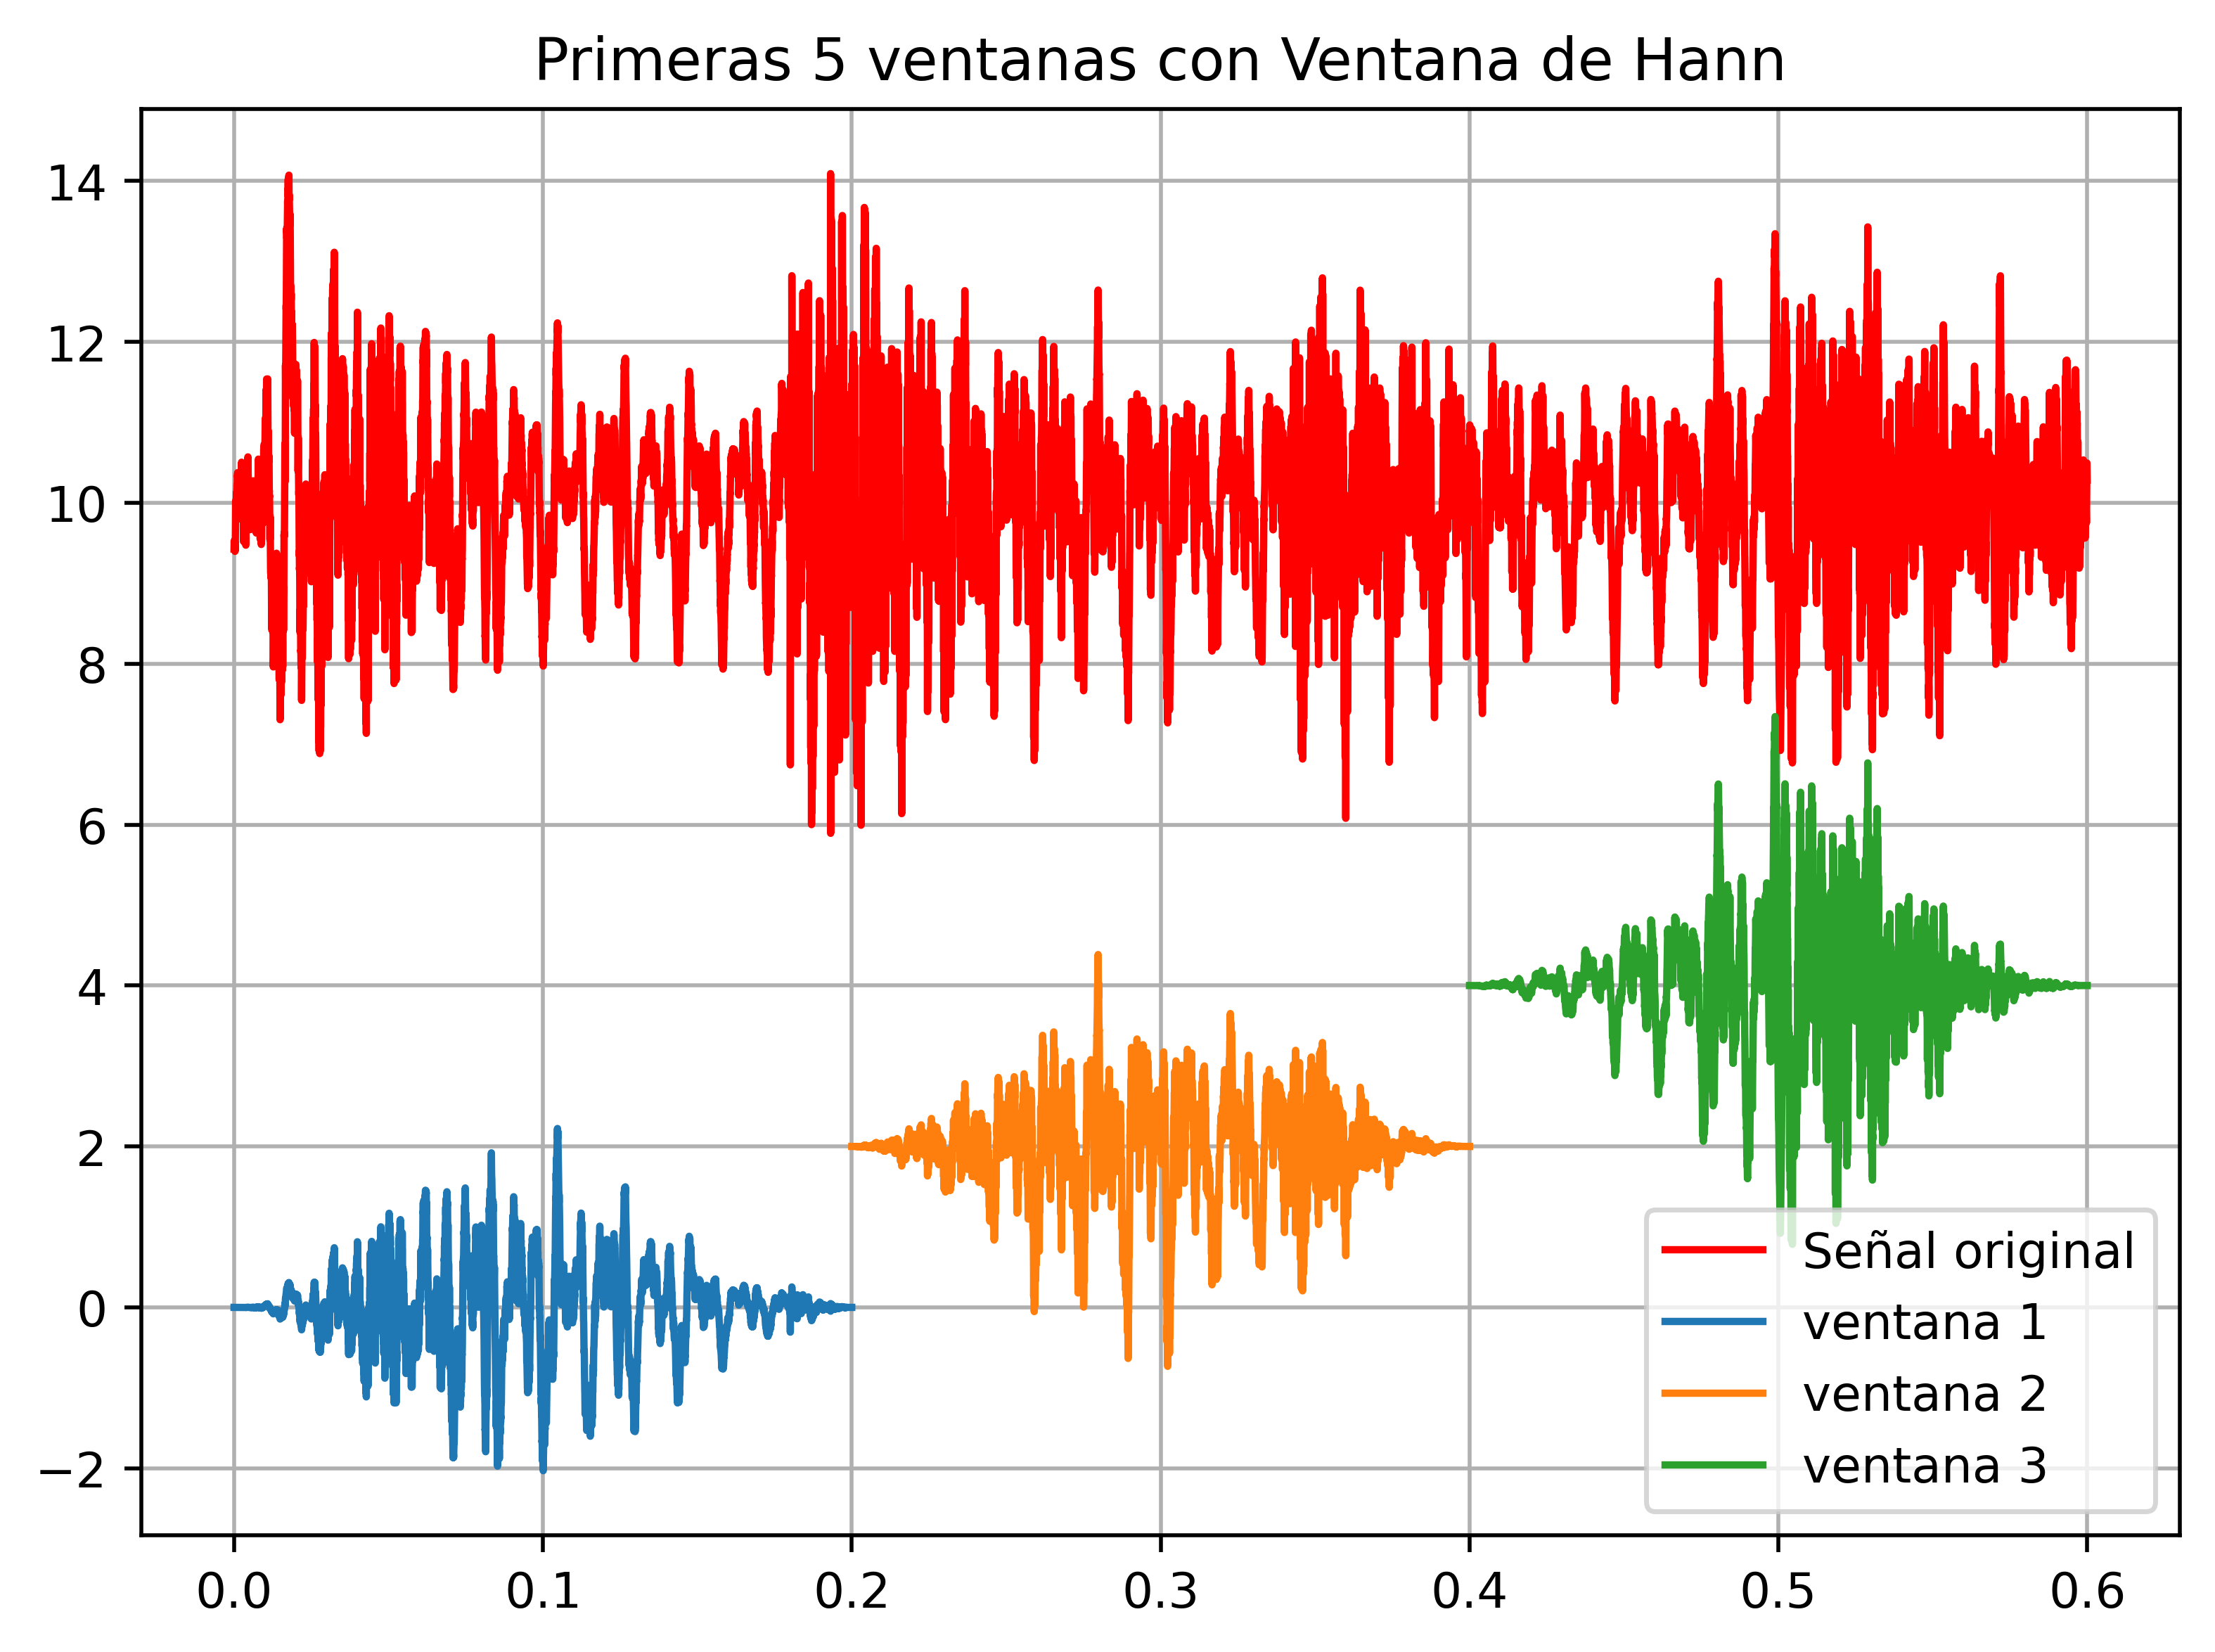

In [ ]:
#@title Correr esta celda solo si va a graficar
x = dfSenhal.sNorm.values[100]
fs=44100
t = np.linspace(0,len(x)/44100,len(x))
ventana = ventana_audio(x,44100)
ventanas_rectangulares = np.reshape(a=x,newshape=(int(len(x)/int(0.2*44100)),int(int(0.2*44100))))
ventana_tiempo = np.reshape(a=t,newshape=(int(len(x)/int(0.2*44100)),int(int(0.2*44100))))

figure,ax = plt.subplots(dpi=500)
ax.plot(t[0*fs:int(0.6*fs)],x[0*fs:int(0.6*fs)]+10,color='r')
for i in range(3):
  ax.plot(ventana_tiempo[i,:],ventana[i,:]+i*2)
  ax.grid()
ax.legend(['Señal original','ventana 1','ventana 2','ventana 3'])
ax.set_title('Primeras 5 ventanas con Ventana de Hann')
figure.tight_layout()
figure.savefig('../document/img/Ventaneo_señales.png')

## **3. Extracción de características**

---



### **3.1. Características temporales**

---

*   **ZRC:** Tasa de cruce por cero
*   **Energía:** Energía de la señal
*   **Entropia:** Entropia de la señal



In [ ]:
def energia_senhal(x,fs):
  '''
  Calcula la energía de la señal utilizando el método de integración simpson
  Variables de entrada:
    x (array): el vector de la señal
    fs (int): frecuencia de muestreo
  Variable de salida:
    energía de la señal (float)
  '''
  t = np.linspace(0,int(len(x)/fs),len(x))
  T = 1/fs
  return simps(np.power(x,2),t)

def entropia_senhal(x):
  '''
  Determina la entropía de la señal x
  Variables de entrada:
    x(array): el vector de la señal
  Variables de salida:
    entropia de la señal (float)
  '''
  unicos, freq = np.unique(x,return_counts=True)
  freq_normalizada = freq/len(freq)
  entropia = -1*np.sum(freq_normalizada*np.log(freq_normalizada))
  return entropia

In [ ]:
dfCaracteristicas = pd.DataFrame({'etiqueta':dfSenhal['etiqueta']})

In [ ]:
dfCaracteristicas['ZRC'] = dfSenhal.sNorm.apply(lambda x: np.sum(zero_crossings(x))/len(x))
dfCaracteristicas['energia'] = dfSenhal.sNorm.apply(lambda x: energia_senhal(x,fs=44100))
dfCaracteristicas['entropia'] = dfSenhal.sNorm.apply(lambda x: entropia_senhal(x))
dfCaracteristicas

,etiqueta,ZRC,energia,entropia
0,pasillo,0.048739,5.000069,44.072536
1,pasillo,0.039365,5.000107,43.033426
2,pasillo,0.075143,4.999808,40.631911
3,pasillo,0.051111,4.999943,49.656443
4,pasillo,0.046925,4.999980,81.766774
...,...,...,...,...
145,carranga,0.053714,4.999579,46.358697
146,carranga,0.073311,4.999719,34.081133
147,carranga,0.081197,4.999813,34.253143
148,carranga,0.071197,5.000572,34.531924


### **3.2. Características espectrales**

---

In [ ]:
from seaborn._core.properties import Optional
def centroide_spread_espectral(s,fs):
  '''
  Obtiene el centroide y la dispersión espectral promedio a partir de las ventanas de una señal.
  entradas:
    s: ventanas
    fs: señal de muestreo
  salida:
    centroide_espectral
    dispersion_espectral
  '''
  cf_s = []
  vf_s = []
  for x in s:
    x_fft_norm = np.abs(fft(x))/np.sum(np.abs(fft(x)))
    f = np.linspace(start=0,stop=fs,num=len(x_fft_norm))
    cf = np.sum(x_fft_norm*f)/np.sum(f)
    vf = np.sum(np.power(f-cf,2)*x_fft_norm)/np.sum(x_fft_norm)
    cf_s.append(cf)
    vf_s.append(vf)
  return np.mean(cf_s), np.mean(vf_s)

def entropia_espectral_ventana(s, n):
  '''
  Determina la entropia para un tramo (ventana) de la señal.
    s: ventana
    n: tramos o particiones del espectro
  retorna:
    entropia.
  '''
  sfft = np.abs(fft(s)) # Espectro de la ventana
  eTotal = np.sum(np.power(sfft,2))
  tramos_espectro = np.reshape(a=sfft, newshape=(n,int(len(sfft)/n)))
  eTramos = np.sum(np.power(tramos_espectro,2),axis=1)/eTotal
  entropia = -1*np.sum(eTramos*np.log2(eTramos))
  return entropia

def entropia_espectral_senhal(s,n):
  '''
  determina la entropia de las ventanas de una señal s
    s: array de ventanas de la señal
    n: tramos o particiones del espectro
  entrada:
    entrpias: array de netropias (entropia por ventana)
  '''
  entropias = np.array(list(map(lambda x: entropia_espectral_ventana(x,n=20),s)))
  return entropias

def calcular_roll_off(s:np.ndarray, fs:np.float64, roll_off: np.float64):
  """
  Determina el roll-off del espectro.
    s [np.adarray]: Ventana de la señal
    fs [np.float64]: Frecuencia de muestreo
    roll_off [np.float64]: Valor de roll-off (0 y 1)
  Retorna:
    roll_off[np.float64]: Valor de la frecuencia roll-off
  """
  roll_off = list(map(lambda x: feature.spectral_rolloff(y=x, sr=fs, roll_percent=roll_off)[0][-1],s))
  return roll_off

def calcular_vector_chroma(s:np.ndarray,fs:np.float64):
  '''
  Obtienen el vector de chroma a partir del chronograma.
    s[np.ndarray]: señal/audio
    fs[np.float64]: frecuencia de muestreo
  retorna:
    chroma_vector[np.ndarray]: Vector chroma de 12 elementos C, C#, D, D#, E, F, F#, G, G#, A, A#, B  
  '''
  chroma = feature.chroma_stft(y=s, sr=fs)
  chroma_vector = np.mean(chroma, axis=1)
  return chroma_vector

In [ ]:
dfCaracteristicas['centroide_dispersion'] = dfSenhal.ventanas.apply(lambda x: centroide_spread_espectral(x,44100))
dfCaracteristicas['centroideE'] = dfCaracteristicas['centroide_dispersion'].apply(lambda x: x[0])
dfCaracteristicas['dispersionE'] = dfCaracteristicas['centroide_dispersion'].apply(lambda x: x[1])
dfCaracteristicas.drop(['centroide_dispersion'],axis=1,inplace=True)
dfCaracteristicas['entropias'] = dfSenhal.ventanas.apply(lambda x: entropia_espectral_senhal(x,n=20))
dfCaracteristicas['roll_off'] = dfSenhal.ventanas.apply(lambda x: calcular_roll_off(s=x,fs=44100, roll_off=0.95))
dfCaracteristicas['vector_chroma'] = dfSenhal.sNorm.apply(lambda x: calcular_vector_chroma(s=x,fs=44100))

In [ ]:
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropias,roll_off,vector_chroma
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,"[1.8430492793015458, 1.4947242856926586, 1.670...","[5986.23046875, 5318.701171875, 5254.1015625, ...","[0.5547170310225635, 0.47001668776588096, 0.56..."
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,"[0.6501101666151647, 1.7124758061600323, 1.488...","[64.599609375, 6029.296875, 7019.82421875, 566...","[0.3113570914874378, 0.2809049031757559, 0.353..."
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,"[0.6501101666151647, 2.645029800902688, 2.3215...","[64.599609375, 7622.75390625, 7105.95703125, 7...","[0.4531311083134227, 0.4140833625042305, 0.425..."
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,"[0.6534243544950055, 1.4619169236133966, 1.265...","[19358.349609375, 7364.35546875, 5943.1640625,...","[0.4850550837033671, 0.40093473131179014, 0.47..."
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,"[1.0944514050915615, 1.0232773943508309, 1.044...","[11197.265625, 7816.552734375, 6890.625, 11714...","[0.43719094687377924, 0.4627364300252315, 0.45..."


In [ ]:
cabeceras_entropia = [f'entropia_{x+1}' for x in range(25)]
splitEntropias = pd.DataFrame(dfCaracteristicas['entropias'].to_list(), columns=cabeceras_entropia)
dfCaracteristicas = pd.concat([dfCaracteristicas,splitEntropias], axis=1)
dfCaracteristicas.drop(['entropias'],axis=1, inplace=True)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,roll_off,vector_chroma,entropia_1,entropia_2,...,entropia_16,entropia_17,entropia_18,entropia_19,entropia_20,entropia_21,entropia_22,entropia_23,entropia_24,entropia_25
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,"[5986.23046875, 5318.701171875, 5254.1015625, ...","[0.5547170310225635, 0.47001668776588096, 0.56...",1.843049,1.494724,...,1.547369,1.207757,1.701165,1.525699,1.378038,1.369197,1.959379,1.956875,1.166306,1.268028
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,"[64.599609375, 6029.296875, 7019.82421875, 566...","[0.3113570914874378, 0.2809049031757559, 0.353...",0.650110,1.712476,...,2.158863,1.301950,1.808452,1.293252,1.389713,2.120178,1.253246,2.208974,1.444233,1.617226
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,"[64.599609375, 7622.75390625, 7105.95703125, 7...","[0.4531311083134227, 0.4140833625042305, 0.425...",0.650110,2.645030,...,2.248200,1.796914,2.114551,1.958751,2.235107,2.095227,1.525430,1.149037,2.162559,1.580931
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,"[19358.349609375, 7364.35546875, 5943.1640625,...","[0.4850550837033671, 0.40093473131179014, 0.47...",0.653424,1.461917,...,1.146743,1.504713,1.493916,1.123124,1.436118,1.121867,1.164022,1.955080,1.492531,1.630949
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,"[11197.265625, 7816.552734375, 6890.625, 11714...","[0.43719094687377924, 0.4627364300252315, 0.45...",1.094451,1.023277,...,1.430749,1.475481,1.671941,1.097710,1.288663,1.339886,1.374304,1.151257,1.274863,1.420583


In [ ]:
cabeceras_roll_off = [f'roll_off_{x+1}' for x in range(25)]
splitRollOff = pd.DataFrame(dfCaracteristicas['roll_off'].to_list(),columns=cabeceras_roll_off)
dfCaracteristicas = pd.concat([dfCaracteristicas,splitRollOff],axis=1)
dfCaracteristicas.drop(['roll_off'],axis=1,inplace=True)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,vector_chroma,entropia_1,entropia_2,entropia_3,...,roll_off_16,roll_off_17,roll_off_18,roll_off_19,roll_off_20,roll_off_21,roll_off_22,roll_off_23,roll_off_24,roll_off_25
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,"[0.5547170310225635, 0.47001668776588096, 0.56...",1.843049,1.494724,1.670651,...,4285.107422,9733.007812,20671.875000,8462.548828,4651.171875,6416.894531,8979.345703,11412.597656,10702.001953,6718.359375
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,"[0.3113570914874378, 0.2809049031757559, 0.353...",0.650110,1.712476,1.488205,...,20262.744141,6976.757812,4715.771484,6503.027344,5318.701172,5857.031250,6632.226562,5512.500000,6136.962891,6007.763672
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,"[0.4531311083134227, 0.4140833625042305, 0.425...",0.650110,2.645030,2.321534,...,18023.291016,16580.566406,6782.958984,19013.818359,19702.880859,8074.951172,7708.886719,5641.699219,7428.955078,6955.224609
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,"[0.4850550837033671, 0.40093473131179014, 0.47...",0.653424,1.461917,1.265949,...,7493.554688,8828.613281,6847.558594,5232.568359,8807.080078,8031.884766,9603.808594,8764.013672,7019.824219,7859.619141
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,"[0.43719094687377924, 0.4627364300252315, 0.45...",1.094451,1.023277,1.044737,...,9087.011719,11261.865234,9194.677734,6395.361328,9173.144531,8764.013672,9216.210938,7730.419922,11068.066406,9173.144531


In [ ]:
chroma_to_key = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
splitChroma = pd.DataFrame(dfCaracteristicas['vector_chroma'].to_list(),columns=chroma_to_key)
dfCaracteristicas = pd.concat([dfCaracteristicas,splitChroma],axis=1)
dfCaracteristicas.drop(['vector_chroma'],axis=1,inplace=True)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,D,D#,E,F,F#,G,G#,A,A#,B
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,0.564289,0.411354,0.411571,0.321868,0.314890,0.467014,0.415298,0.465048,0.378498,0.423678
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,0.353748,0.386825,0.540517,0.646196,0.460341,0.381447,0.303921,0.253463,0.269267,0.260341
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,0.425207,0.487614,0.589706,0.645507,0.644200,0.599062,0.487733,0.456368,0.357914,0.333159
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,0.472084,0.334685,0.419466,0.550746,0.357001,0.320093,0.424537,0.615070,0.575013,0.448353
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,0.452232,0.612146,0.377835,0.278290,0.225351,0.345143,0.394501,0.308183,0.390825,0.327518


### **3.3. Características ceptrales (Coeficientes de Mel)**

---



In [ ]:
def calcular_MFCC(s:np.ndarray, fs: np.float64):
  '''
  Determina los primeros 14 coeficientes de Mel
    s[np.ndarray]: Señal/audio
    fs[np.float64]: Frecuencia de muestreo
  retorna:
    mel_vector[np.ndarray]: vector de coeficientes de tamaño 14  
  '''
  return np.mean(feature.mfcc(y=s,sr=44100),axis=1)[0:13]

In [ ]:
dfCaracteristicas['MFCC'] = dfSenhal.sNorm.apply(lambda x: calcular_MFCC(s=x,fs=44100))
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,D#,E,F,F#,G,G#,A,A#,B,MFCC
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,0.411354,0.411571,0.321868,0.314890,0.467014,0.415298,0.465048,0.378498,0.423678,"[39.878016911812196, 148.2518978599066, -22.09..."
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,0.386825,0.540517,0.646196,0.460341,0.381447,0.303921,0.253463,0.269267,0.260341,"[-51.99174357650128, 137.33716094487048, -45.5..."
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,0.487614,0.589706,0.645507,0.644200,0.599062,0.487733,0.456368,0.357914,0.333159,"[-5.613932027156661, 108.3325003043487, -52.70..."
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,0.334685,0.419466,0.550746,0.357001,0.320093,0.424537,0.615070,0.575013,0.448353,"[-1.3362422631684674, 151.51630597416818, -33...."
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,0.612146,0.377835,0.278290,0.225351,0.345143,0.394501,0.308183,0.390825,0.327518,"[-8.520919067006764, 154.36291219118374, -25.3..."


In [ ]:
cabeceras_mfcc = [f'mfcc_{x+1}' for x in range(13)]
splitMFCC = pd.DataFrame(dfCaracteristicas['MFCC'].to_list(),columns=cabeceras_mfcc)
dfCaracteristicas = pd.concat([dfCaracteristicas,splitMFCC],axis=1)
dfCaracteristicas.drop(['MFCC'],axis=1,inplace=True)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,33.478379,-3.536323,17.277049,-8.447565,6.750127,-2.842041,-0.063743,-4.715555,-8.982431,-3.674320
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,58.606227,25.199873,-1.665875,13.110995,1.282471,-3.003319,-11.864987,-10.513642,-13.933441,-9.220807
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,66.236557,13.255364,12.773686,14.923173,6.326210,12.820073,-2.746832,-2.469320,-14.211967,-10.282409
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,58.518026,-11.547021,12.927332,-5.079591,7.197690,2.616833,-5.918656,-4.921344,-9.386932,1.568965
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,43.471646,-25.589739,30.462998,-14.585496,2.303008,-21.459797,-5.475361,-3.261887,-11.878058,5.442998


### **3.4. Características Wavelet**

---



In [ ]:
def determinar_medidas_wavelet(x:np.ndarray):
  '''
  Determina tres estadísticas (media, desviación y potencia) a partir de los
  coeficientes de detalle de tres níveles de la transformada de wavelet.
    x[np.ndarray]: Señal/audio
  Retorna:
    meann1[np.float64]: media de los coefientes del primer nivel
    meann2[np.float64]: media de los coefientes del segundo nivel
    meann3[np.float64]: media de los coefientes del terccer nivel
    std1[np.float64]: desviación estandar de los coeficientes del primer nivel
    std2[np.float64]: desviación estandar de los coeficientes del segundo nivel
    std3[np.float64]: desviación estandar de los coeficientes del tercer nivel
    pown1[np.float64]: potencia de los coeficientes del primer nivel
    pown2[np.float64]: potencia de los coeficientes del segundo nivel
    pown3[np.float64]: potencia de los coeficientes del tercer nivel
  '''
  cA,cD = pywt.dwt(x,'db4')
  cAn1, cDn1 = pywt.dwt(cA,'db4') # 1 nivel
  cAn2, cDn2 = pywt.dwt(cAn1,'db4') # 2 nivel
  cAn3, cDn3 = pywt.dwt(cAn2,'db4') # 3 nivel
  meann1 = cDn1.mean()
  meann2 = cDn2.mean()
  meann3 = cDn3.mean()
  std1 = cDn1.std()
  std2 = cDn2.std()
  std3 = cDn3.std()
  pown1 = np.sum(np.abs(cDn1))/len(cDn1)
  pown2 = np.sum(np.abs(cDn2))/len(cDn2)
  pown3 = np.sum(np.abs(cDn3))/len(cDn3)
  return [meann1, meann2, meann3, std1, std2, std3, pown1, pown2, pown3]


In [ ]:
dfCaracteristicas['wavelet'] = dfSenhal.sNorm.apply(determinar_medidas_wavelet)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,wavelet
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,-3.536323,17.277049,-8.447565,6.750127,-2.842041,-0.063743,-4.715555,-8.982431,-3.674320,"[-0.00037056500901790746, -0.00260770563246381..."
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,25.199873,-1.665875,13.110995,1.282471,-3.003319,-11.864987,-10.513642,-13.933441,-9.220807,"[0.0009609960684712347, 0.0014166392467256012,..."
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,13.255364,12.773686,14.923173,6.326210,12.820073,-2.746832,-2.469320,-14.211967,-10.282409,"[-0.00038551304471427783, -0.00104864534823284..."
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,-11.547021,12.927332,-5.079591,7.197690,2.616833,-5.918656,-4.921344,-9.386932,1.568965,"[0.00039033298951367484, 0.000474015038345313,..."
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,-25.589739,30.462998,-14.585496,2.303008,-21.459797,-5.475361,-3.261887,-11.878058,5.442998,"[-0.00031301996367546033, 0.001081606080912227..."


In [ ]:
cabeceras_wavelet = ['meann1', 'meann2', 'meann3', 'std1', 'std2', 'std3', 'pown1', 'pown2', 'pown3']
splitWavelet = pd.DataFrame(dfCaracteristicas['wavelet'].to_list(),columns=cabeceras_wavelet)
dfCaracteristicas = pd.concat([dfCaracteristicas,splitWavelet],axis=1)
dfCaracteristicas.drop(['wavelet'],axis=1,inplace=True)
dfCaracteristicas.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,mfcc_13,meann1,meann2,meann3,std1,std2,std3,pown1,pown2,pown3
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,-3.674320,-0.000371,-0.002608,0.004303,0.282719,0.597057,1.008631,0.127094,0.357351,0.687432
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,-9.220807,0.000961,0.001417,-0.000627,0.301205,0.704524,0.821963,0.139982,0.427447,0.513147
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,-10.282409,-0.000386,-0.001049,0.005575,0.416683,0.970003,1.145082,0.228944,0.638908,0.739955
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,1.568965,0.000390,0.000474,0.001446,0.245500,0.571364,0.886408,0.141615,0.363127,0.586545
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,5.442998,-0.000313,0.001082,0.002024,0.184742,0.350896,0.905379,0.117002,0.243219,0.639961


In [ ]:
dfCaracteristicas.to_csv('../Data/conjunto_datos.csv',index=False)

## **4. Normalización y partición de las características**

---



### **4.1. Normalización del conjunto de datos**

---



In [ ]:
def normalizar_datos(x):
  normalizador = Normalizer().fit(x.reshape(1,-1))
  xNormalizado = normalizador.transform(x.reshape(1,-1))
  return xNormalizado.reshape(-1,1)

In [4]:
dfVector = pd.read_csv('../Data/conjunto_datos.csv')
dfVector.head(5)

,etiqueta,ZRC,energia,entropia,centroideE,dispersionE,entropia_1,entropia_2,entropia_3,entropia_4,...,mfcc_13,meann1,meann2,meann3,std1,std2,std3,pown1,pown2,pown3
0,pasillo,0.048739,5.000069,44.072536,0.000113,8.356661e+08,1.843049,1.494724,1.670651,1.364131,...,-3.674320,-0.000371,-0.002608,0.004303,0.282719,0.597057,1.008631,0.127094,0.357351,0.687432
1,pasillo,0.039365,5.000107,43.033426,0.000111,8.435378e+08,0.650110,1.712476,1.488205,1.722330,...,-9.220807,0.000961,0.001417,-0.000627,0.301205,0.704524,0.821963,0.139982,0.427447,0.513147
2,pasillo,0.075143,4.999808,40.631911,0.000111,8.155467e+08,0.650110,2.645030,2.321534,2.252236,...,-10.282409,-0.000386,-0.001049,0.005575,0.416683,0.970003,1.145082,0.228944,0.638908,0.739955
3,pasillo,0.051111,4.999943,49.656443,0.000112,8.623325e+08,0.653424,1.461917,1.265949,1.897992,...,1.568965,0.000390,0.000474,0.001446,0.245500,0.571364,0.886408,0.141615,0.363127,0.586545
4,pasillo,0.046925,4.999980,81.766774,0.000113,8.758882e+08,1.094451,1.023277,1.044737,1.155031,...,5.442998,-0.000313,0.001082,0.002024,0.184742,0.350896,0.905379,0.117002,0.243219,0.639961


In [ ]:
columnas = dfVector.columns[1::]
for col in columnas:
    dfVector[col] = normalizar_datos(dfVector[col].values)
dfVector.head(5)
dfVector.to_csv('../Data/conjunto_datos_normalizado.csv',index=False)

### **4.2. Partición del conjunto de datos**

---



In [5]:
dfVector = pd.read_csv('../Data/conjunto_datos_normalizado.csv')

In [6]:
Y_label = dfVector['etiqueta'].values
X_features = dfVector.drop(['etiqueta'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X_features,
                                                    Y_label,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=Y_label)

In [7]:
print('Características:', X_features.shape)
print('Etiquetas:', Y_label.shape)
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)

Características: (150, 89)
Etiquetas: (150,)
Entrenamiento: (120, 89)
Testeo: (30, 89)


## **5. Análisis de Componentes Principales (PCA)**

---



In [8]:
def cumulative_explained_variance_plot(expl_variance):
  cum_var_exp = np.cumsum(expl_variance)
  plt.figure(dpi = 100, figsize = (10, 10))
  plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales',
            fontdict= dict(family ='serif', size = 16))
  plt.xlabel('Número de componentes principales',
             fontdict= dict(family ='serif', size = 14))
  plt.ylabel('Varianza explicada acumulativa',
             fontdict= dict(family ='serif', size = 14))
  nc = np.arange(1, expl_variance.shape[0] + 1)
  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'b*', ms = 5)
  plt.grid()
  plt.savefig('../document/img/pca.png')
  plt.show()

In [9]:
pca = PCA(n_components=40)
pca.fit(X_train)
X_t = pca.transform(X_train)

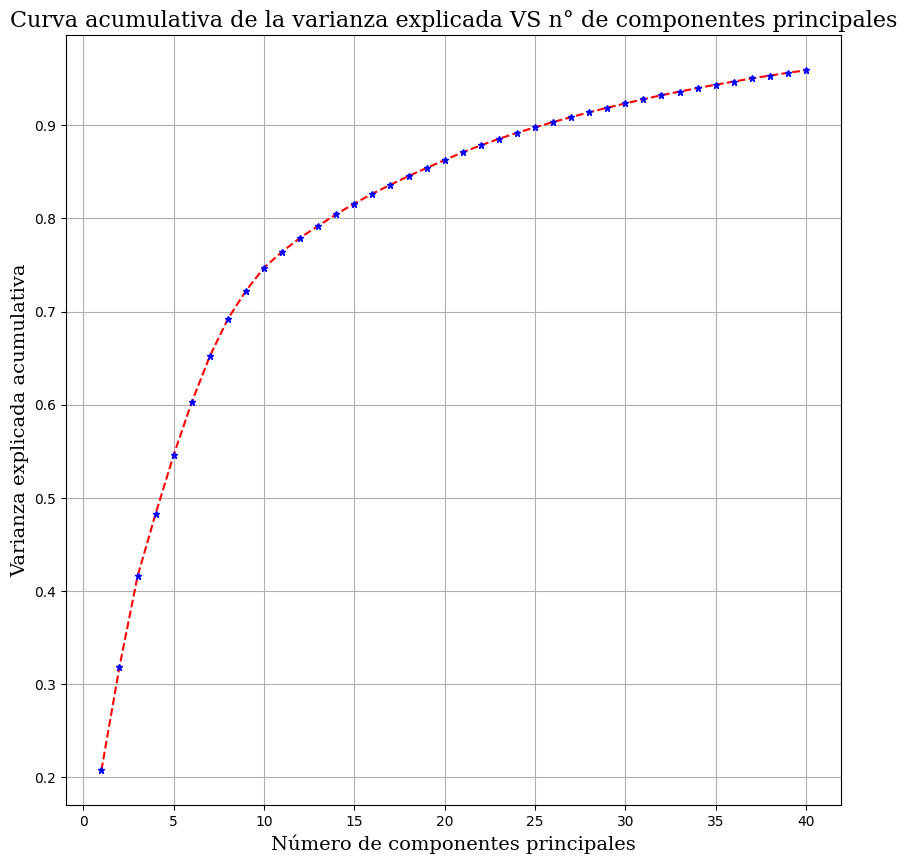

In [10]:
cumulative_explained_variance_plot(pca.explained_variance_ratio_)

In [11]:
pca_final = PCA(n_components=25)
pca_final.fit(X=X_train)
joblib.dump(pca_final,'../scripts/artifacts/pca.sav')
X_pca = pca_final.transform(X=X_train)

## **6. Entrenamiento**

---



### **6.1. Árboles de decisión**

---



In [ ]:
hiperparametros = {
    'n_estimators': np.arange(100,1000,100),
    'max_depth': np.arange(10,1000,50)
}

In [ ]:
random_forest = RandomForestClassifier(random_state=1234)
grid_bosque = GridSearchCV(estimator=random_forest,
                           param_grid=hiperparametros,
                           cv=5,
                           verbose=1)
grid_bosque.fit(X=X_pca,y=y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             param_grid={'max_depth': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960]),
                         'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
             verbose=1)

In [ ]:
modelo_mejor = grid_bosque.best_estimator_
modelo_mejor

RandomForestClassifier(max_depth=10, n_estimators=400, random_state=1234)

In [ ]:
joblib.dump(modelo_mejor,'../scripts/artifacts/random_forest.sav')

['/content/drive/MyDrive/MAESTRÍA/RECONOCIMIENTO ESTADÍSTICO DE PATRONES/Artefactos/random_forest.sav']

### **6.2. Clasificador Bayesiano**

---



In [ ]:
hiperparametros = {
    'var_smoothing': np.linspace(1e-9,1,100)
}

In [ ]:
bayes_model =  GaussianNB()
grid_bayes = GridSearchCV(estimator=bayes_model,
                           param_grid=hiperparametros,
                           cv=5,
                           verbose=1)
grid_bayes.fit(X=X_pca,y=y_train.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e-09, 1.01010111e-02, 2.02020212e-02, 3.03030313e-02,
       4.04040414e-02, 5.05050515e-02, 6.06060615e-02, 7.07070716e-02,
       8.08080817e-02, 9.09090918e-02, 1.01010102e-01, 1.11111112e-01,
       1.21212122e-01, 1.31313132e-01, 1.41414142e-01, 1.51515152e-01,
       1.61616162e-01, 1.71717173e-01, 1.81...
       7.67676768e-01, 7.77777778e-01, 7.87878788e-01, 7.97979798e-01,
       8.08080808e-01, 8.18181818e-01, 8.28282828e-01, 8.38383839e-01,
       8.48484849e-01, 8.58585859e-01, 8.68686869e-01, 8.78787879e-01,
       8.88888889e-01, 8.98989899e-01, 9.09090909e-01, 9.19191919e-01,
       9.29292929e-01, 9.39393939e-01, 9.49494950e-01, 9.59595960e-01,
       9.69696970e-01, 9.79797980e-01, 9.89898990e-01, 1.00000000e+00])},
             verbose=1)

In [ ]:
modelo_mejor = grid_bayes.best_estimator_
modelo_mejor

GaussianNB(var_smoothing=0.010101011090909091)

In [ ]:
joblib.dump(modelo_mejor,'../scripts/artifacts/clasificador_bayes.savor_bayes.sav')

### **6.3. Perceptrón multicapa**

---



In [62]:
def label_enconder(y_train):
  encoder_clase_train = LabelEncoder().fit(y_train)
  y_train_enc = encoder_clase_train.transform(y_train)
  joblib.dump(encoder_clase_train,'../scripts/artifacts/encoder_train.sav')
  return y_train_enc

def one_hot_labels(y_train_enc, y_test_enc):
  y_train_ohe = tf.keras.utils.to_categorical(y=y_train_enc)
  y_test_ohe = tf.keras.utils.to_categorical(y=y_test_enc)
  return y_train_ohe, y_test_ohe

In [13]:
# Codificación de las etiquetas
y_train_enc, y_test_enc = label_enconder(y_test=y_test, y_train=y_train)
y_train_ohe, y_test_ohe = one_hot_labels(y_train_enc, y_test_enc)

In [14]:
def define_model(input_shape, hidden_layers, hidden_units, output_units):
  tf.keras.utils.set_random_seed(0)
  input_layer = tf.keras.layers.Input(shape=(input_shape,))
  for i in range(hidden_layers):
    if i==0:
      Y = tf.keras.layers.Dense(units=hidden_units,activation='relu')(input_layer)
    else:
      Y = tf.keras.layers.Dense(units=hidden_units,activation='relu')(Y)
  output_layer = tf.keras.layers.Dense(units=output_units,activation='sigmoid')(Y)
  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
  return model


def compile_model(model, loss, optimizer, metrics):
  tf.keras.utils.set_random_seed(0)
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  return model


def define_callbacks(filepath, metric, mode, patience):
  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath=filepath,
      monitor=metric,
      mode=mode,
      save_best_only=True,
      save_weights_only=True
      )
  stopping = tf.keras.callbacks.EarlyStopping(
      monitor=metric,
      patience=patience,
      mode=mode,
      restore_best_weights=True
      )
  callbacks = [checkpoint, stopping]
  return callbacks


def train_model(model, X_train, y_ohe_train, epochs, batch_size, validation_rate, callbacks):
  tf.keras.utils.set_random_seed(0)
  history = model.fit(
      x=X_train,
      y=y_ohe_train,
      epochs=epochs,
      batch_size=batch_size,
      callbacks=callbacks,
      validation_split=validation_rate
      )
  return history, model

In [54]:
modelo = define_model(input_shape=X_pca.shape[1],
                      hidden_layers=2,
                      hidden_units=16,
                      output_units=5)
print(modelo.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_12 (Dense)            (None, 16)                416       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 5)                 85        
                                                                 
Total params: 773 (3.02 KB)
Trainable params: 773 (3.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [55]:
modelo = compile_model(modelo,
                       tf.keras.losses.categorical_crossentropy,
                       tf.keras.optimizers.Adam(learning_rate=1e-4),
                       metrics = ['acc'])
modelo.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': False,
   'is_legacy_optimizer': False,
   'learning_rate': 9.999999747378752e-05,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': {'module': 'builtins',
  'class_name': 'function',
  'config': 'categorical_crossentropy',
  'registered_name': 'function'},
 'metrics': ['acc'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [56]:
checkpoint, stopping = define_callbacks('../scripts/artifacts/test_checkpoint.h5', 'loss', 'min', 2)
print('ModelCheckpoint setup:\n',
      '\nmonitor =',checkpoint.monitor,
      '\npath =',checkpoint.filepath,
      '\nsave_best_only =', checkpoint.save_best_only)
print('\nEarlyStopping setup:\n',
      '\nmonitor =',stopping.monitor,
      '\npatience =',stopping.patience,
      '\nrestore_best_only =', stopping.restore_best_weights)

ModelCheckpoint setup:
 
monitor = loss 
path = /content/drive/MyDrive/MAESTRÍA/RECONOCIMIENTO ESTADÍSTICO DE PATRONES/Artefactos/test_checkpoint.h5 
save_best_only = True

EarlyStopping setup:
 
monitor = loss 
patience = 2 
restore_best_only = True


In [63]:
history, modelo = train_model(model=modelo,
                             X_train=X_pca,
                             y_ohe_train=y_train_ohe,
                             epochs=1500,
                             batch_size=50,
                             validation_rate=0.3,
                             callbacks=[checkpoint, stopping])

Epoch 1/1500
2/2 [==============================] - 0s 324ms/step - loss: 0.8948 - acc: 0.7381 - val_loss: 1.4075 - val_acc: 0.4722
Epoch 2/1500
2/2 [==============================] - 0s 52ms/step - loss: 0.8944 - acc: 0.7381 - val_loss: 1.4075 - val_acc: 0.4722
Epoch 3/1500
2/2 [==============================] - 0s 56ms/step - loss: 0.8939 - acc: 0.7381 - val_loss: 1.4074 - val_acc: 0.4722
Epoch 4/1500
2/2 [==============================] - 0s 68ms/step - loss: 0.8934 - acc: 0.7381 - val_loss: 1.4075 - val_acc: 0.4722
Epoch 5/1500
2/2 [==============================] - 0s 51ms/step - loss: 0.8930 - acc: 0.7381 - val_loss: 1.4076 - val_acc: 0.4722
Epoch 6/1500
2/2 [==============================] - 0s 56ms/step - loss: 0.8925 - acc: 0.7381 - val_loss: 1.4077 - val_acc: 0.4722
Epoch 7/1500
2/2 [==============================] - 0s 47ms/step - loss: 0.8920 - acc: 0.7381 - val_loss: 1.4078 - val_acc: 0.4722
Epoch 8/1500
2/2 [==============================] - 0s 63ms/step - loss: 0.8916 - 

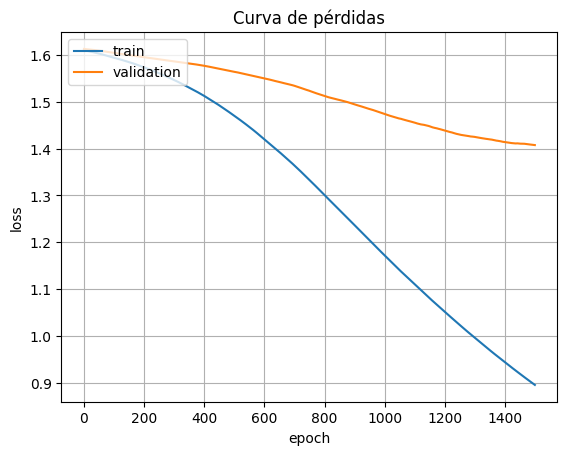

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Curva de pérdidas')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

## **7. Evaluación**

---



In [44]:
modelo_pca = joblib.load('../scripts/artifacts/pca.sav')
encoder_test = joblib.load('../scripts/artifacts/encoder_test.sav')

In [ ]:
modelo_bosque = joblib.load('../scripts/artifacts/random_forest.sav')
modelo_bosque

In [ ]:
Y_pred = modelo_bosque.predict(modelo_pca.transform(X_test))

<Axes: >

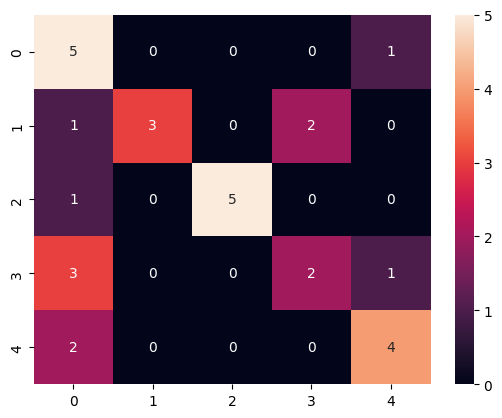

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=Y_pred),annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=Y_pred, zero_division=0))

              precision    recall  f1-score   support

    carranga       0.42      0.83      0.56         6
      cumbia       1.00      0.50      0.67         6
      joropo       1.00      0.83      0.91         6
     pasillo       0.50      0.33      0.40         6
   vallenato       0.67      0.67      0.67         6

    accuracy                           0.63        30
   macro avg       0.72      0.63      0.64        30
weighted avg       0.72      0.63      0.64        30



In [ ]:
modelo_bayes = joblib.load('../scripts/artifacts/clasificador_bayes.sav')
modelo_bayes

GaussianNB(var_smoothing=0.010101011090909091)

In [ ]:
Y_pred = modelo_bayes.predict(modelo_pca.transform(X_test))

<Axes: >

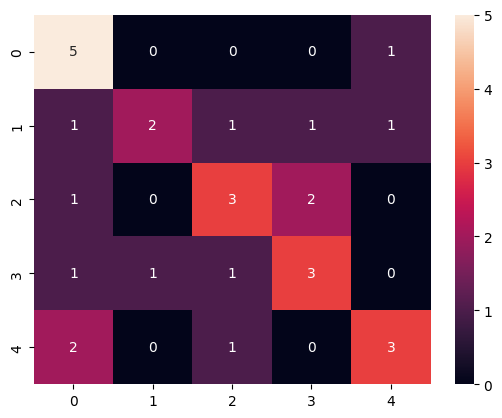

In [ ]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=Y_pred),annot=True)

In [ ]:
print(classification_report(y_true=y_test, y_pred=Y_pred, zero_division=0))

              precision    recall  f1-score   support

    carranga       0.50      0.83      0.62         6
      cumbia       0.67      0.33      0.44         6
      joropo       0.50      0.50      0.50         6
     pasillo       0.50      0.50      0.50         6
   vallenato       0.60      0.50      0.55         6

    accuracy                           0.53        30
   macro avg       0.55      0.53      0.52        30
weighted avg       0.55      0.53      0.52        30



In [58]:
Y_pred = encoder_test.inverse_transform(modelo.predict(modelo_pca.transform(X_test)).argmax(axis=1))

1/1 [==============================] - 0s 65ms/step


<Axes: >

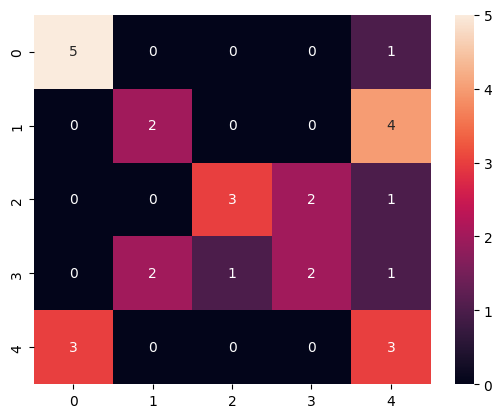

In [59]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=Y_pred),annot=True)

In [60]:
print(classification_report(y_true=y_test, y_pred=Y_pred, zero_division=0))

              precision    recall  f1-score   support

    carranga       0.62      0.83      0.71         6
      cumbia       0.50      0.33      0.40         6
      joropo       0.75      0.50      0.60         6
     pasillo       0.50      0.33      0.40         6
   vallenato       0.30      0.50      0.37         6

    accuracy                           0.50        30
   macro avg       0.53      0.50      0.50        30
weighted avg       0.54      0.50      0.50        30

